In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.stats as stats
import septum_mec.analysis.data_processing as dp
import head_direction.head as head
import spatial_maps as sp
import septum_mec.analysis.registration
import speed_cells.speed as spd
import septum_mec.analysis.spikes as spikes
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import septum_mec
import scipy.ndimage.measurements
from distutils.dir_util import copy_tree
from spike_statistics.core import theta_mod_idx

from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`


In [3]:
max_speed = 1, # m/s only used for speed score
min_speed = 0.02, # m/s only used for speed score
position_sampling_rate = 100 # for interpolation
position_low_pass_frequency = 6 # for low pass filtering of position

box_size = [1.0, 1.0]
bin_size = 0.02
smoothing_low = 0.03
smoothing_high = 0.06

stim_mask = True
baseline_duration = 600

In [4]:
project_path = dp.project_path()

project = expipe.get_project(project_path)
actions = project.actions

In [5]:
identify_neurons = actions['identify-neurons']
units = pd.read_csv(identify_neurons.data_path('units'))
units.head()

,action,channel_group,max_depth_delta,max_dissimilarity,unit_id,unit_idnum,unit_name
0,1834-010319-1,0,100,0.05,ae0353a9-a406-409e-8ff7-2e940b8af03f,327,2
1,1834-010319-1,0,100,0.05,7f514d43-17ba-4d88-a390-20eec8bc1378,328,39
2,1834-010319-3,0,100,0.05,c977aa51-06cc-4d54-9430-a94ad422a03b,329,1
3,1834-010319-3,0,100,0.05,bd96a67d-ee7d-4cb6-90ab-a5fa751891b9,330,12
4,1834-010319-4,0,100,0.05,abc01041-2971-4f62-bf06-5132cf356737,332,7


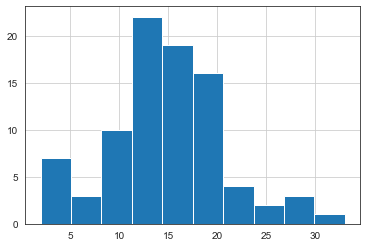

In [6]:
%matplotlib inline
units.groupby('action').count().unit_name.hist()

In [7]:
data_loader = dp.Data(
    position_sampling_rate=position_sampling_rate, 
    position_low_pass_frequency=position_low_pass_frequency,
    box_size=box_size, bin_size=bin_size, stim_mask=stim_mask, baseline_duration=baseline_duration
)

In [47]:
# first_row = units[units['action'] == '1833-060319-3'].iloc[0]

from septum_mec.analysis.statistics import load_data_frames
data, _,_,_ = load_data_frames()

Number of sessions above threshold 194
Number of animals 4
Number of individual gridcells 139
Number of gridcell recordings 230


In [83]:
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (10, 10), 
    'figure.dpi': 150
})

noisy_gridness                   1.138187
noisy_information_rate           1.864017
noisy_information_specificity    0.360965
gridness                         1.154121
information_rate                 2.528118
information_specificity          0.789860
dtype: float64

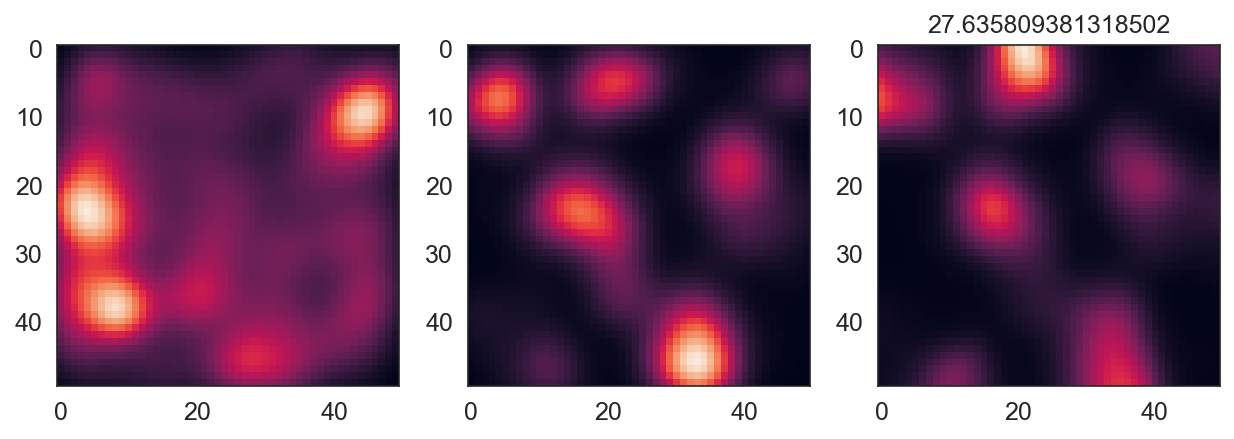

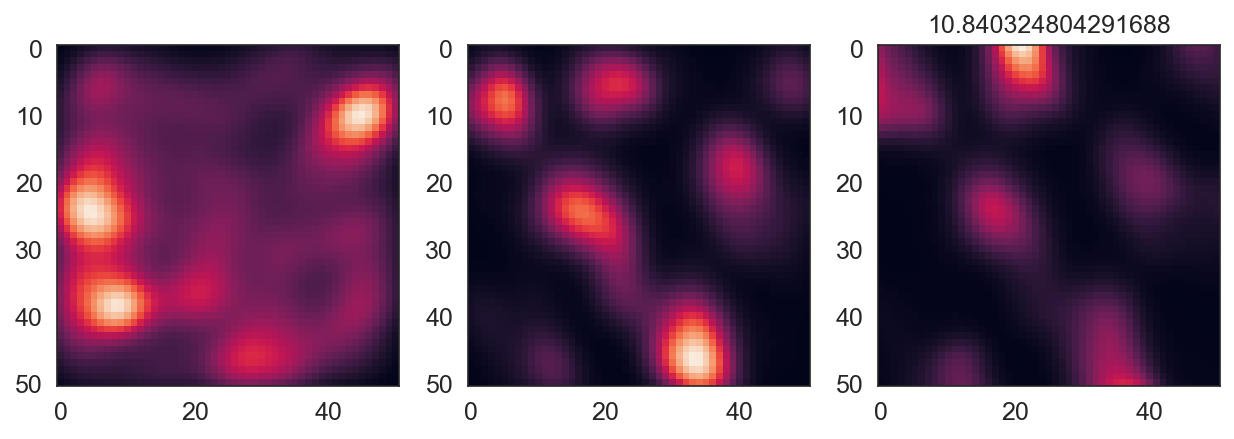

In [87]:
def process(row):
    action_id = row['action']
    channel_id = row['channel_group']
    unit_id = row['unit_name']
    
    # common values for all units == faster calculations
    x, y, t, speed = map(data_loader.tracking(action_id).get, ['x', 'y', 't', 'v'])
#     ang, ang_t = map(data_loader.head_direction(action_id).get, ['a', 't'])
    
    occupancy_map = data_loader.occupancy(action_id)
    xbins, ybins = data_loader.spatial_bins
    box_size_, bin_size_ = data_loader.box_size_, data_loader.bin_size_
    prob_dist = data_loader.prob_dist(action_id)
    
#     smooth_low_occupancy_map = sp.maps.smooth_map(
#         occupancy_map, bin_size=bin_size_, smoothing=smoothing_low)
    smooth_high_occupancy_map = sp.maps.smooth_map(
        occupancy_map, bin_size=bin_size_, smoothing=smoothing_high)
            
    spike_times = data_loader.spike_train(action_id, channel_id, unit_id)
    if len(spike_times) == 0:
        result = pd.Series({
            'noisy_gridness': np.nan,
            'noisy_information_rate': np.nan,
            'noisy_information_specificity': np.nan
        })
        return result
    
    # common
    spike_map = sp.maps._spike_map(x, y, t, spike_times, xbins, ybins)

#     smooth_low_spike_map = sp.maps.smooth_map(spike_map, bin_size=bin_size_, smoothing=smoothing_low)
    smooth_high_spike_map = sp.maps.smooth_map(spike_map, bin_size=bin_size_, smoothing=smoothing_high)

#     smooth_low_rate_map = smooth_low_spike_map / smooth_low_occupancy_map
    smooth_high_rate_map = smooth_high_spike_map / smooth_high_occupancy_map
    
    
    
    noisy_ratemap = smooth_high_rate_map + np.random.random(smooth_high_rate_map.shape) * smooth_high_rate_map.mean()
    noisy_gridness = sp.gridness(noisy_ratemap)
    
    noisy_information_rate = stats.information_rate(noisy_ratemap, prob_dist)
    
    noisy_information_spec = stats.information_specificity(noisy_ratemap, prob_dist)
    
    information_rate = stats.information_rate(smooth_high_rate_map, prob_dist)
    
    information_spec = stats.information_specificity(smooth_high_rate_map, prob_dist)
    
    
    gridness = sp.gridness(smooth_high_rate_map)
    
#     fig, (ax1, ax2) = plt.subplots(1,2)
#     ax1.imshow(smooth_high_rate_map)
#     ax1.set_title(gridness)
#     ax2.imshow(noisy_ratemap)
#     ax2.set_title(noisy_gridness)
    
#     fig, (ax1, ax2) = plt.subplots(1,2)
#     ax1.imshow(occupancy_map)
#     ax1.set_title((occupancy_map / len(x)).max())
#     ax2.imshow(prob_dist)
#     ax2.set_title(prob_dist.max())
    
    from scipy.interpolate import interp1d
    from scipy.stats import gaussian_kde
    
    sx = interp1d(t, x)(spike_times)
    sy = interp1d(t, y)(spike_times)
        
    X, Y = np.meshgrid(xbins, ybins)
    positions = np.vstack([X.ravel(), Y.ravel()])
    
    xy = np.vstack([x, y])
    t_ = np.append(t, t[-1] + np.median(np.diff(t)))
    time_in_bin = np.diff(t_)
    bw = 0.2
    s_xy = np.vstack([sx, sy])
    kernel = gaussian_kde(s_xy, bw_method=bw)
    smap = np.reshape(kernel(positions), X.shape)
    
#     kernel = gaussian_kde(xy, weights=time_in_bin, bw_method=bw)
    kernel = gaussian_kde(xy, bw_method=bw)
    omap = np.reshape(kernel(positions), X.shape)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    ax1.imshow(smooth_high_occupancy_map)
    ax2.imshow(smooth_high_spike_map)
    ax3.imshow(smooth_high_rate_map)
    ax3.set_title(smooth_high_rate_map.max())
    
    omap = np.flipud(np.rot90(omap))
    smap = np.flipud(np.rot90(smap))
    rmap = smap / omap
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    ax1.imshow(omap)
    ax2.imshow(smap)
    ax3.imshow(rmap)
    ax3.set_title(rmap.max())


    result = pd.Series({
        'noisy_gridness': noisy_gridness,
        'noisy_information_rate': noisy_information_rate,
        'noisy_information_specificity': noisy_information_spec,
        'gridness': gridness,
        'information_rate': information_rate,
        'information_specificity': information_spec,
    })
    return result
        
process(data.sort_values('gridness', ascending=False).iloc[0])

In [21]:
results = units.merge(
    units.progress_apply(process, axis=1), 
    left_index=True, right_index=True)

In [22]:
output_path = pathlib.Path("output") / "calculate-statistics-extra"
output_path.mkdir(exist_ok=True)

In [23]:
results.to_csv(output_path / "results.csv", index=False)

# Store results in Expipe action

In [24]:
statistics_action = project.require_action("calculate-statistics-extra")

In [25]:
statistics_action.data["results"] = "results.csv"
copy_tree(output_path, str(statistics_action.data_path()))

['/media/storage/expipe/septum-mec/actions/calculate-statistics-extra/data/results.csv']

In [26]:
statistics_action.modules['parameters'] = {
    'max_speed': max_speed,
    'min_speed': min_speed,
    'position_sampling_rate': position_sampling_rate,
    'position_low_pass_frequency': position_low_pass_frequency,
    'box_size': box_size,
    'bin_size': bin_size,
    'smoothing_low': smoothing_low,
    'smoothing_high': smoothing_high,
    'stim_mask': stim_mask,
    'baseline_duration': baseline_duration
}

In [27]:
septum_mec.analysis.registration.store_notebook(statistics_action, "10_calculate_statistics_extra.ipynb")

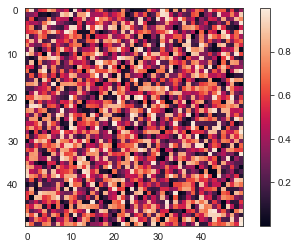

In [35]:
plt.imshow(np.random.random((50,50)))
plt.colorbar()